In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from typing import List
from torch.utils.data import Dataset, DataLoader
import torch

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#!pip install transformers

#Предобработка данных и анализ

In [3]:
df = pd.read_csv('train_spam.csv')
df_push = pd.read_csv('test_spam.csv')
df

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


## Проверка на пропуски в данных

In [4]:
df.isna().sum()

text_type    0
text         0
dtype: int64

In [5]:
df_push.isna().sum()

text    0
dtype: int64

Пропуска в данных
не наблюдается

## Изучим баланс классов в данных

In [6]:
df['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

In [7]:
print(round(4809 / (11469 + 4809) * 100), '% наблюдений относится к спаму')

30 % наблюдений относится к спаму


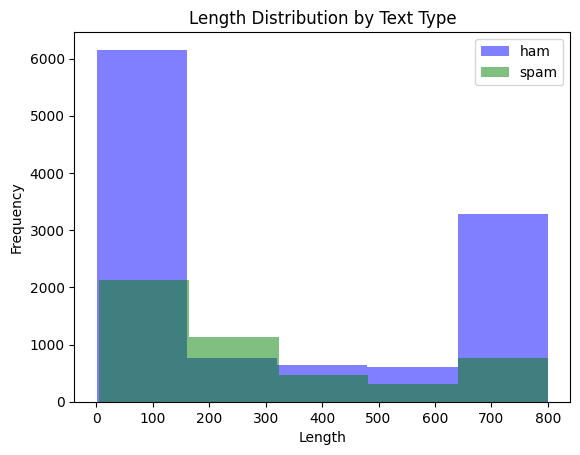

In [8]:
import matplotlib.pyplot as plt

# Создание столбца с длиной текста
df["length"] = df["text"].apply(len)

# Сортировка DataFrame по длине текста и вывод первых 10 строк
sorted_df = df.sort_values(by='length', ascending=False).head(10)

# Построение гистограммы
plt.hist(df[df['text_type'] == 'ham']['length'], bins=5, alpha=0.5, label='ham', color='blue')
plt.hist(df[df['text_type'] == 'spam']['length'], bins=5, alpha=0.5, label='spam', color='green')

# Настройка графика
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Length Distribution by Text Type')
plt.legend()

# Отображение графика
plt.show()


 По данному графику на глаз не выделить четкой особенности спама, то что короткой длины сообщения намного чаще являются не спамом, возможно списывается на дисбаланс классов в нашей выборке

In [9]:
df['text_type'] = df['text_type'].apply(lambda x: 0 if x == 'ham' else 1)

## разделим train_csv данные на тренировочный и валидационные

In [10]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

## Токенайзеры и векторы

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train['text'])
print('Shape of the matrix:', X.shape)

Shape of the matrix: (11394, 43683)


In [12]:
def contains_digit(s: str) -> bool:
    for i in s:
        if  i.isdigit():
            break
    return i.isdigit()

def contains_punctuation(s: str) -> bool:
    punc = '''!()-[]{};?@#$%:'"\,./^&;*_=+|`~'''
    for i in punc:
        if i in s:
            break
    return i in s

def is_hashtag(s: str) -> bool:
    return s.startswith('#')

def is_mention(s: str) -> bool:
    return s.startswith('@')
def investigate_vocabulary(vocabulary):
    dig, pun, has, men = 0, 0, 0, 0
    for i in vocabulary:
        if contains_digit(i):
            dig += 1
        if contains_punctuation(i):
            pun += 1
        if is_hashtag(i):
            has += 1
        if is_mention(i):
            men += 1
    print('With digit:      ',
          dig)
    print('With punctuation:',
          pun)
    print('Hashtags:        ',
          has)
    print('Mentions:        ',
          men)




In [13]:
investigate_vocabulary(
    cnt_vec.vocabulary_
                       )

With digit:       4767
With punctuation: 0
Hashtags:         0
Mentions:         0


В нашем датасете имеется 4767 наблюдений с цифрами внутри текста

## Изменим токенайзер

In [14]:
from nltk.tokenize import TweetTokenizer

In [15]:
def twt(text):
    tw = TweetTokenizer()
    return tw.tokenize(text)

cnt_vec = CountVectorizer(tokenizer=twt)
X = cnt_vec.fit_transform(train['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
investigate_vocabulary(
                       cnt_vec.vocabulary_
                       )

With digit:       4197
With punctuation: 406
Hashtags:         0
Mentions:         338


Tweet tokenizer упоминания в то время как до него у нас было их по 0. Это связанно с тем, что он настроен на работу с определенными символами и лучше отделяет упомнинания и хештеги. Также при использовании словарь увеличился на 1200~ токенов, что помогло улучшить качество анализа.

## Токенизация и стемминг

In [17]:
from nltk.stem.snowball import SnowballStemmer
import nltk
nltk.download('stopwords')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def contains_only_latin_letters(s: str) -> bool:
    return s.isalpha()

def is_emoji(s: str) -> bool:
    punc = '''!()-[]{};?@#$%:'"\,./^&;*_=+|`~'''
    sig = 0
    si = 0
    for i in s:
        if i == ')' or i == '(':
            sig = 1
        if i not in punc:
            si = 0
            break
        else:
            si = 1
    if si == 1 and sig == 1:
        return si == 1



def is_hashtag(s: str) -> bool:
    return (s.startswith('#') and s[1:].isalpha())

def custom_tokenizer(s: str) -> List[str]:
    s = s.lower()
    tw = TweetTokenizer()

    s = tw.tokenize(s)

    s = [i for i in s if
          (contains_only_latin_letters(i) or
          is_emoji(i) or
          is_hashtag(i)) and
          (i not in nltk.corpus.stopwords.words('english'))]

    s = [stemmer.stem(w) for w in s]
    return s

## Применение на данных

In [19]:
vectorizer = CountVectorizer(
                             tokenizer = custom_tokenizer)

y_train, X_train, X_test, y_test = train['text_type'], train['text'], test['text'], test['text_type']

new_train = cnt_vec.fit_transform(X_train)
new_test = cnt_vec.transform(X_test)
print('Shape of the matrix:', new_train.shape)

Shape of the matrix: (11394, 44557)


# Применение первой модели: Логистическая регресия

In [20]:
from sklearn.linear_model import LogisticRegression
cl = LogisticRegression().fit(new_train, y_train)
prediction = cl.predict(new_test)
prediction_train = cl.predict(new_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


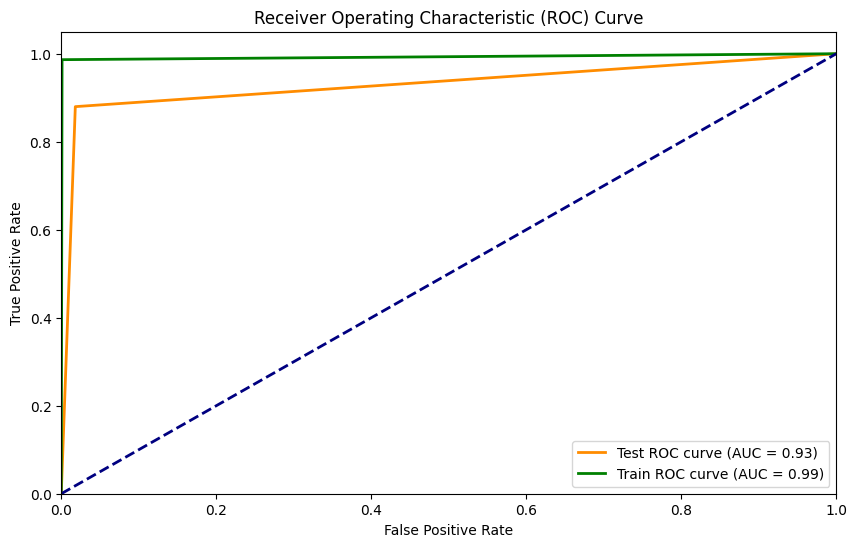

Test ROC AUC: 0.9308033252898172
Train ROC AUC: 0.9927426174610154


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# ROC-AUC score
test_roc_auc = roc_auc_score(y_test, prediction)
train_roc_auc = roc_auc_score(y_train, prediction_train)

#ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, prediction)
fpr_train, tpr_train, _ = roc_curve(y_train, prediction_train)

plt.figure(figsize=(10, 6))

plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)

plt.plot(fpr_train, tpr_train, color='green', lw=2, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)

# Plot random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Test ROC AUC:", test_roc_auc)
print("Train ROC AUC:", train_roc_auc)


### для кастомизированого токенайзера:
*Test ROC AUC: 0.9120515671558583
Train ROC AUC: 0.9869540950865432*

### для чистого tweettoken:
*Test ROC AUC: 0.9308033252898172
Train ROC AUC: 0.9927426174610154*

По целевой метрике лучшее значение показывает TweetTokenizer запомним результат с ним

# Применение второй модели: Случайный лес

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Создание и обучение модели случайного леса
rf = RandomForestClassifier()
rf.fit(new_train, y_train)

# Прогнозирование на тестовых и тренировочных данных
prediction = rf.predict(new_test)
prediction_train = rf.predict(new_train)

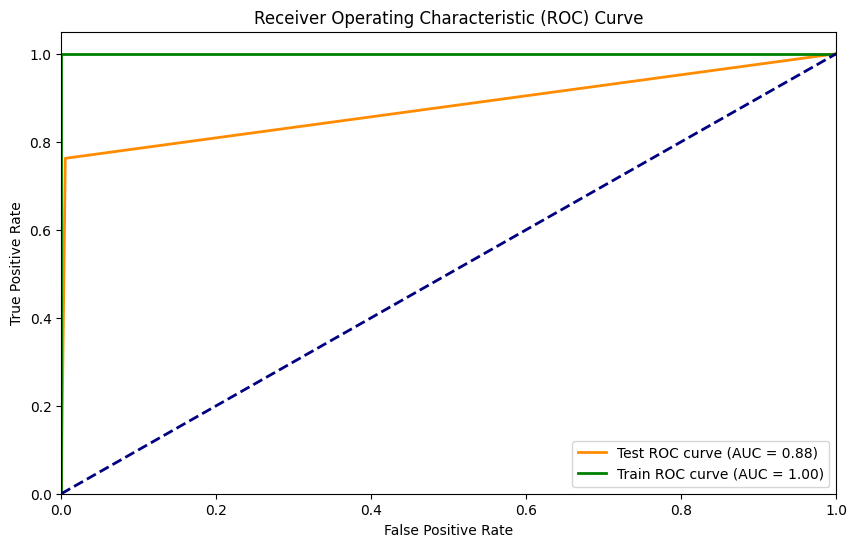

Test ROC AUC: 0.8785518397625202
Train ROC AUC: 1.0


In [43]:
# ROC-AUC score
test_roc_auc = roc_auc_score(y_test, prediction)
train_roc_auc = roc_auc_score(y_train, prediction_train)

#ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, prediction)
fpr_train, tpr_train, _ = roc_curve(y_train, prediction_train)

plt.figure(figsize=(10, 6))

plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)

plt.plot(fpr_train, tpr_train, color='green', lw=2, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)

# Plot random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Test ROC AUC:", test_roc_auc)
print("Train ROC AUC:", train_roc_auc)

Test ROC AUC: 0.8785 хуже качество чем у логистической регрессии возможно именно из-за переобучения леса, пока выбираем логистическую регрессию

# Посмотрим иную модель

In [22]:
train

,text_type,text,length
3080,0,these are being advertised all over the uk chi...,203
12194,0,tamil music channel,19
3794,0,no i dont have cancer moms making a big deal o...,83
1501,0,job description good afternoon here is the job...,239
11567,0,rofl its true to its name,25
...,...,...,...
13418,0,transition to research group an update molly j...,739
5390,0,avistar users and allocated charges avistar ha...,568
860,1,account for sale 💕total mythics 23💕 🥳account l...,474
15795,0,a a program question gwyn just because the a a...,748


In [23]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
df['text'] = df['text'].apply(lambda x: x.lower())

## Подгружаем предобученную модель 'distilbert-base-uncased'

In [26]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['text_type'], test_size=0.3)

model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model f

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [27]:
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

In [28]:
class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [29]:
train_dataset = EmailDataset(train_encodings, train_labels.tolist())
test_dataset = EmailDataset(test_encodings, test_labels.tolist())

In [30]:
#!pip install accelerate -U

In [31]:
#!pip install transformers

In [32]:
#pip install transformers==4.30

In [33]:
#pip install bitsandbytes

In [34]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True if device.type == 'cuda' else False,
    load_best_model_at_end=True
)

In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.138900,0.111824
2,0.059700,0.116109
3,0.008100,0.101448


TrainOutput(global_step=1071, training_loss=0.12680326509319878, metrics={'train_runtime': 619.4957, 'train_samples_per_second': 55.177, 'train_steps_per_second': 1.729, 'total_flos': 4528000620859392.0, 'train_loss': 0.12680326509319878, 'epoch': 3.0})

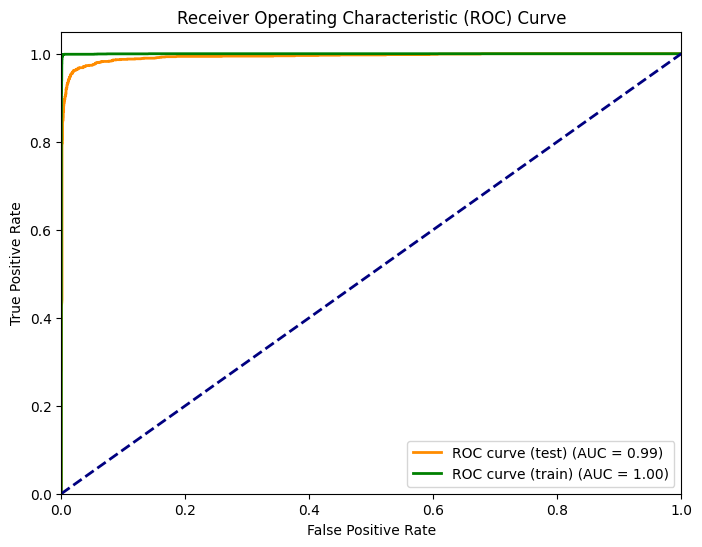

Test ROC AUC: 0.9934192675420745
Train ROC AUC: 0.9997718238099769


In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


test_probs = trainer.predict(test_dataset)[0]
train_probs = trainer.predict(train_dataset)[0]

#ROC-AUC
test_roc_auc = roc_auc_score(test_labels, test_probs[:, 1])
train_roc_auc = roc_auc_score(train_labels, train_probs[:, 1])

#ROC curve
fpr_test, tpr_test, _ = roc_curve(test_labels, test_probs[:, 1])
fpr_train, tpr_train, _ = roc_curve(train_labels, train_probs[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (test) (AUC = %0.2f)' % test_roc_auc)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='ROC curve (train) (AUC = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Test ROC AUC:", test_roc_auc)
print("Train ROC AUC:", train_roc_auc)


## Сравнивая две модели
### лог-рег:
*Test ROC AUC: 0.9308
Train ROC AUC: 0.9927*
### DistilBert:
*Test ROC AUC: 0.9934
Train ROC AUC: 0.9998*

### DistilBert показал лучшие результаты слежовательно его мы и будем использовать

Задача классификации спама может включать в себя выявление сложных зависимостей между словами и фразами, которые логистическая регрессия может не улавливать эффективно. DistilBERT способен выучивать более сложные иерархические зависимости между словами и фразами благодаря своей архитектуре трансформера. DistilBERT предварительно обучается на больших корпусах текстов на естественном языке (например, на Википедии, новостных статьях и т.д.), что позволяет модели обучаться на обширном объеме данных. Это может быть особенно полезно, так как у нас ограниченное количество размеченных данных для задачи классификации спама.

# Применим лучшую модель на тестовых данных и запишем результат в csv-файл

In [40]:
df_push

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


In [41]:

encodings = tokenizer(df_push['text'].tolist(), truncation=True, padding=True)


dummy_labels = [0] * len(df_push)


new_dataset = EmailDataset(encodings, labels=dummy_labels)

#предсказания для нового датасета
predictions = trainer.predict(new_dataset)

results_df = pd.DataFrame({'score': predictions.predictions.argmax(axis=1), 'text': df_push['text']})

results_df['score'] = results_df['score'].apply(lambda x: 'spam' if x == 1 else 'ham')

results_df.to_csv("results.csv", index=False)

In [44]:
final = pd.read_csv('results.csv')
final

,score,text
0,ham,j jim whitehead ejw cse ucsc edu writes j you ...
1,ham,original message from bitbitch magnesium net p...
2,ham,java for managers vince durasoft who just taug...
3,ham,there is a youtuber name saiman says
4,spam,underpriced issue with high return on equity t...
...,...,...
4065,ham,husband to wifetum meri zindagi hoorwifeor kya...
4066,ham,baylor enron case study cindy yes i shall co a...
4067,ham,boring as compared to tp
4068,ham,hellogorgeous hows u my fone was on charge lst...
